In [150]:
import wave, numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import sounddevice as sd

# readfile
def audio_prep(file_name,txt_name,plot=1,listen=1,noise=0):
    fs,x_wave = wavfile.read(file_name)
    interval = np.genfromtxt(txt_name, delimiter='\t')
    

    
    x = x_wave.astype(float)
    if(noise>0):
        x += np.random.normal(0, x.max()*noise,x.shape)
        
    x_play = x.astype(int)    
    # spectrogram
    if(x.shape==(x.shape[0],)):
        f, t, Sxx = signal.spectrogram(x, fs,window=("hann"))
    else:
        f, t, Sxx = signal.spectrogram(x[:,0], fs,window=("hann"))
    if(plot == 1):
        plt.pcolormesh(t, f, np.log(Sxx+1e-8))
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
        print("Sxx.max = ",Sxx.max())

    #Sxx /= Sxx.max()
    #Sxx = -np.log(Sxx+1e-9)
    Sxx /= Sxx.max()
    labels = np.zeros(Sxx.shape[1])
    print("Sxx.shape=",Sxx.shape)
    
            
    print("interval.shape=",interval.shape)       
    if(interval.shape == (2,)):     
        if(listen==1):
            sd.play(x_play,fs,blocking=True)
        bb,ee = int(interval[0]*fs),min(int(interval[1]*fs),(x.shape[0]))
        print("interval=",interval)
        if(plot == 1):
            
            print("fs=",fs)
            print(x.shape)
            plt.plot(np.linspace(start=0,stop=(x_play.shape[0]/fs),num=x_play.shape[0]),\
                    np.linspace(start=0,stop=0,num=x_play.shape[0]))
            plt.plot(np.linspace(start=interval[0],stop=interval[1],num=int((interval[1]-interval[0])*fs)),\
                   x_play[bb:ee,0])
            plt.plot(np.linspace(start=0,stop=interval[0],num=int((interval[0])*fs)),\
                   x_play[0:bb,0])
            if(ee<x.shape[0]):
                plt.plot(np.linspace(start=interval[1],stop=x.shape[0]/fs,num=int((x.shape[0]-ee))),\
                   x_play[ee+1:,0])
            #plt.plot(np.linspace(start=0,stop=x.shape[0]/fs,num=int(x.shape[0])),x[:,0])
            plt.show()

        #Sxx  = 1-Sxx
        t_bb= int(t.shape[0]*bb/x_play.shape[0])+1
        t_ee= int(t.shape[0]*ee/x_play.shape[0])
        print("t_begin=",t_bb,"t_end=",t_ee)

        # laybel_gen - 0 is everything else, 1 is scream class            
        for i in range(t_bb,t_ee):
            labels[i] = 1

        for i in range(0,len(labels)):
            labels[i] = int(labels[i])
        Sxx = np.hstack((Sxx,0.7*Sxx[:,int(t_bb/3):t_bb+int((t_ee-t_bb)/2)],0.8*Sxx[:,0:t_bb+int((t_ee-t_bb)/2)]))
        labels = np.hstack((labels,labels[int(t_bb/3):t_bb+int((t_ee-t_bb)/2)],labels[0:t_bb+int((t_ee-t_bb)/2)]))
        if(plot == 1):
            plt.plot(labels)
            plt.show()
            plt.plot(Sxx.T[t_bb-1])
            plt.show()
        return Sxx.T,labels
    
    else:
        Sxx_prev = Sxx[:,0:2]
        labels_prev = np.zeros(Sxx_prev.shape[1])
        print("interval=",interval)
        print("fs=",fs)
        print(x.shape)
        for j in range(0,interval.shape[0]):
            bb,ee = int(interval[j][0]*fs),int(interval[j][1]*fs)  
            
            
                

            # get the frame number of the starting and ending frames
            t_bb= int(t.shape[0]*bb/x_play.shape[0])+1
            t_ee= int(t.shape[0]*ee/x_play.shape[0])
            #print(Sxx_prev.shape, Sxx[:,max(int(t_bb/3),int(t_bb-30)):min(Sxx.shape[1],t_ee+30)].shape)
            Sxx_prev = np.hstack((Sxx_prev, Sxx[:,max(int(t_bb/3),int(t_bb-30)):min(Sxx.shape[1],t_ee+30)]))
            # laybel_gen - 0 is everything else, 1 is scream class            
            for i in range(t_bb,t_ee):
                labels[i] = 1
            for i in range(0,len(labels)):
                labels[i] = int(labels[i])
            
            labels_prev   = np.hstack((labels_prev,labels[max(int(t_bb/3),int(t_bb-100)):min(Sxx.shape[1],t_ee+100)]))
            print("t_begin=",t_bb,"t_end=",t_ee)
        t_tmp = np.linspace(start=0,stop=Sxx_prev.shape[1]*x_play.shape[0]/t.shape[0]/fs,num =Sxx_prev.shape[1])
        plt.pcolormesh(t_tmp, f, np.log(Sxx_prev+1e-8))
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
        
        return Sxx_prev.T,labels_prev

In [86]:
def test_inference(file_name,txt_name,R_Net,listen=0,noise=0):
    Sxx_in, labels = audio_prep(file_name,txt_name,plot=0,listen=listen,noise=noise)
        
    result = [];
    compare = [];
    ps = int((n**2)%Sxx_in.shape[0])
    ps = np.clip(ps,0,Sxx_in.shape[0]-2*lenRec-1)
    ps = 0 
    for i in range(0,Sxx_in.shape[0]):
        infer_in_enc = Sxx_in[ps+i]

        ret = R_Net.get_prob(infer_in_enc)
        result.append(ret)
        compare.append(labels[ps+i])

    plt.plot(result)
    plt.plot(compare)
    plt.show()
    print("error variance =",np.var(np.array(result)-np.array(compare)))

In [87]:
#from LSTMbiDir import *
#from RNNbiDir import *
from LSTMSingle import *
#from RNNSingle import *

Sxx.shape= (129, 955)


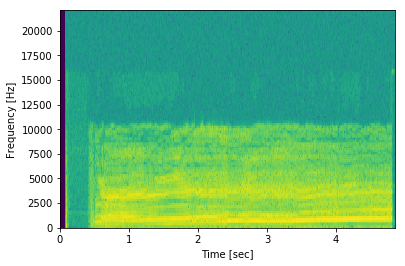

Sxx.max =  277288848450791.9
interval.shape= (2,)
interval= [0.737 4.853]
fs= 44100
(214016, 2)


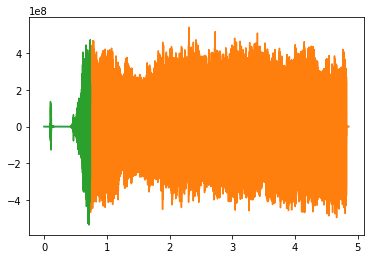

t_begin= 146 t_end= 955


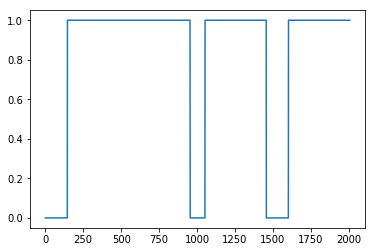

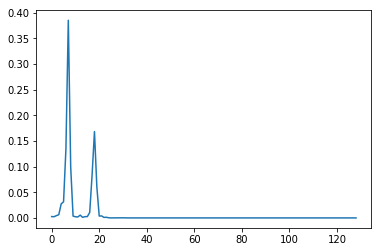

lenIn= 129  lenOut= 2  lenRec= 150


In [124]:
epoch = 30*1000;
Sxx_in,labels = audio_prep("./audio_set/data/file_11001.wav","./audio_set/text/file_11.txt",plot=1,listen=1,noise=0)

lenIn, lenOut, lenRec = Sxx_in.shape[1],2, min(150,max(min(100,Sxx_in.shape[0]),int(Sxx_in.shape[0]/10)))
sizeHidden, numHiddenLayer = 50,1;
learningRate = 0.3;

print("lenIn=",lenIn, " lenOut=",lenOut," lenRec=",lenRec)

# single LSTM
R = myRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate); biDir = 0;lstm=1 

# bidir LSTM
#R = lstmRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate); biDir = 1;lstm=1 

# single RNN
#R = basicRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate); biDir = 0;lstm = 0 

# bidir RNN
#R = basicRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate); biDir = 1;lstm = 0 

0 err: -0.06032628064475471


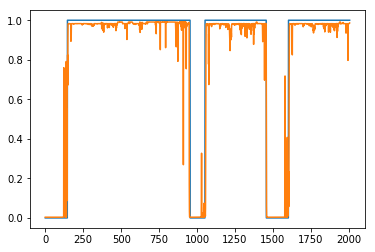

113 err: -0.15979608379028032


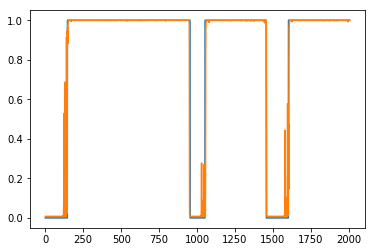

226 err: -0.00015070034402789656


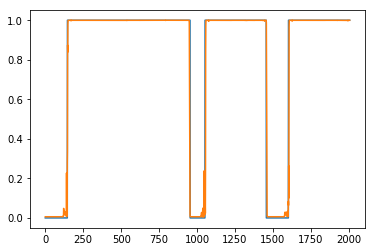

KeyboardInterrupt: 

In [129]:
# training
n,position = 0,0;
while n<epoch:
    
    if(position+lenRec+1 >= Sxx_in.shape[0] or n == 0):
        if(biDir == 0):
            R.h = np.zeros_like(R.h)
            if(lstm != 0):
                R.c = np.zeros_like(R.c)
        else:
            R.hls_infer = np.zeros_like(R.hls_infer)
            R.hrs_infer = np.zeros_like(R.hrs_infer)
            if(lstm != 0):
                R.cls_infer = np.zeros_like(R.cls_infer)
                R.crs_infer = np.zeros_like(R.crs_infer)
        position = 0;
        
    inputs  = Sxx_in[position:position+lenRec]
    targets  = labels[position:position+lenRec]

    R.update_inputs_targets(inputs,targets)
    R.fwd_pass();
    
    err = R.bwd_pass();
    
    if(n%113 == 0 ): # 113 is a prime number
        print(n,"err:",err)
        
        result = []
        compare = []
        ps = 0 
        if(biDir == 0):
            # single layer
            for i in range(0,Sxx_in.shape[0]):
                infer_in_enc = Sxx_in[ps+i]

                ret = R.get_prob(infer_in_enc)
                result.append(ret)
                compare.append(labels[ps+i])
        else:
            # bi-directional
            while(ps+lenRec<Sxx_in.shape[0]):
                infer_in_enc  = Sxx_in[ps:ps+lenRec,:];
                ret = R.inference(infer_in_enc)     
                result.append(ret[:,1])
                compare.append(list(labels[ps:ps+lenRec])[:])
                ps += lenRec
            compare = np.array(compare)
            compare = np.reshape(compare,(compare.shape[0]*compare.shape[1],1))
            result = np.array(result)
            result = np.reshape(result,(result.shape[0]*result.shape[1],1))
        plt.plot(compare)
        plt.plot(result)
        
        plt.show()
    position += lenRec;
    n += 1;



Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955


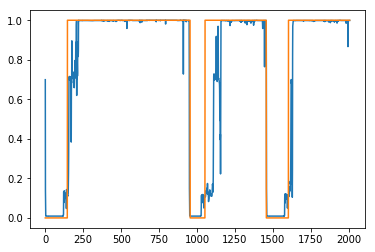

error variance = 0.0376086876697275
Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955


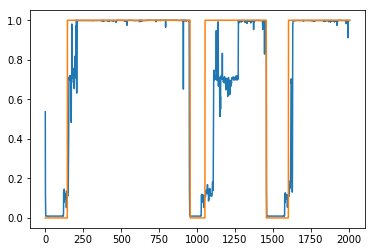

error variance = 0.039497906897316484
Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955


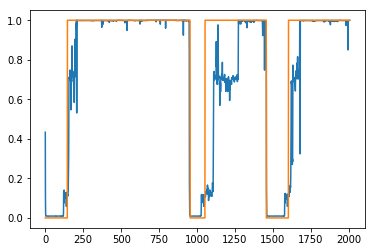

error variance = 0.041036398558393944
Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955


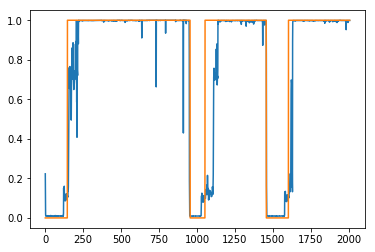

error variance = 0.03599859079843856
Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955


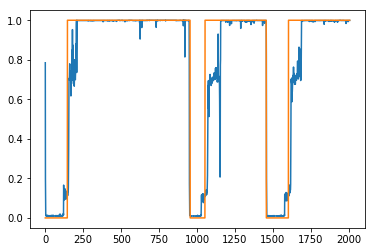

error variance = 0.02661848974961432


In [154]:
for i in range(0,5):
    test_inference("./audio_set/data/file_11001.wav","./audio_set/text/file_11.txt",R,listen=0,noise=i/20)
